In [1]:
import numpy as np
from collections import Counter
from itertools import product
import matplotlib.pyplot as plt

In [2]:
# Ground stae of a Qubit system (in Computational Basis)

Zero = np.array([[1.0],
                 [0.0]])
One = np.array([[0.0],
                [1.0]])

In [3]:
# Single Qubit gates

X = np.array([[0,1],[1,0]],dtype = 'complex_')
Y = np.array([[0,0-1.j],[0+1.j,0]],dtype = 'complex_')
Z = np.array([[1,0],[0,1]],dtype = 'complex_')
H = (1/np.sqrt(2))*np.array([[1,1],[1,-1]],dtype = 'complex_')
I2 = np.array([[1,0],[0,1]],dtype = 'complex_')

# Under Construction

Need to add : 

1. More general comments and Docstrings
2. Try,Except statements to recognize input errors
3. Perhaps implement a OOP-approach for cleaner look

In [4]:
def NTensor_product(*args):
    """Calculate the Tesnor product over a variable number of inputs"""
    result = np.array([[1.0]])
    for element in args:
        result = np.kron(result, element)
    return result  

def get_groundstate(nqubits):
    """Get the groundstate for a #nqubit composite system"""
    qubitlist = [Zero]*nqubits
    groundstate = NTensor_product(*qubitlist)
    return groundstate

def get_operator(nqubits,gatename,target_qubits):
    
    """Return the matrix for a specified Q-gate, no of qubits and target_qubit"""
    
    single_qgates = {'I2':I2,'X':X,'Y':Y,'Z':Z,'H':H}
    if gatename in single_qgates:
        
        # create an array of Identity operations of len = no of qubits
        multiqubitgate_list = np.array([single_qgates['I2'] for i in range(nqubits)])
        # replace Id by Unitary Gate for the target qubit
        multiqubitgate_list[target_qubits[0]] = single_qgates[gatename]
        result = NTensor_product(*multiqubitgate_list)
            
    elif gatename == 'CNOT': 
        # for CNOT we need two inputs the (control,target) qubits
        
        control, target = target_qubits
        
        # Define the projection operators 
        P0 = Zero @  Zero.T
        P1 = One @ One.T
        
        # create two arrays of Identity operations for CNOT
        multiqubitgate_list1 = np.array([single_qgates['I2'] for i in range(nqubits)])
        multiqubitgate_list2 = np.array([single_qgates['I2'] for i in range(nqubits)])
        
        # replace control qubit in list1 and target qubit in list2
        multiqubitgate_list1[control] = P0
        multiqubitgate_list2[control] = P1
        multiqubitgate_list2[target] = single_qgates['X']
        
        result = NTensor_product(*multiqubitgate_list1) + NTensor_product(*multiqubitgate_list2) 
        
        
    return result

def get_fstate(program,istate):
    """Given a program (quantum-circuit), execute it on a given initial state"""
    
    nqubits = np.int(np.log(len(istate))/np.log(2))  # get number of qubits from the given initial state
    fstate = np.copy(istate) # copy the istate vector for fstate
    for operation in program:
        matrix = get_operator(nqubits,operation['gate'],operation['target'])
        fstate = matrix @ fstate  # matrix product
    return fstate


def get_allstates(nqubits):
    """Returns a list of all basis states for a composite system of #nqubits"""
    
    states_list = list(product(['0', '1'], repeat=nqubits)) # gives a list of #qubits combinations of 0,1
    basis_states = [''.join(i) for i in states_list] # concats the entries in states_list to yield basisvectors
    allstates = list(map(lambda x : '|'+str(x)+'>',basis_states)) # moify into ket vectors
    
    return allstates

def measure_all(statevector):
    """Perform measurement on given statevector"""
    probability_dist = abs((statevector**2).real)
    weighted_random_measurement = np.random.choice(range(len(statevector)),1, p=probability_dist.flatten())
    return weighted_random_measurement[0]


def get_counts(statevector,shots):
    """Get Counts for #measurements"""
    
    nqubits = np.int(np.log(len(statevector))/np.log(2))  # get number of qubits from the given statevector
    measurement_results = [measure_all(statevector) for i in range(shots)] #get measurements for all shots
    counter = Counter(measurement_results)  # create a dictionary with measurement results
    
    values = counter.values()
    
    allstates = get_allstates(nqubits)
    newkeys_for_counter = [allstates[int(i)] for i in counter.keys()] # get the ket vectors for the indices in counter
    
    results = dict(zip(newkeys_for_counter,values))
        
    return results

## Two Qubit system

In [15]:
# Basic Qcircuit to obtain Entanglement

qcircuit = [{ "gate": "H", "target": [0] },
            { "gate": "CNOT", "target": [0,1] }]
            
twoq = get_groundstate(nqubits=2) # get ground state
final_state = get_fstate(qcircuit,twoq)  # get the final state for the given ground state and circuit
print('Final state:\n',final_state)
results = get_counts(final_state,shots=1000)  # obtain measurement results
print('\nMeasurement Results:',results)

Final state:
 [[0.70710678+0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.70710678+0.j]]

Measurement Results: {'|11>': 493, '|00>': 507}


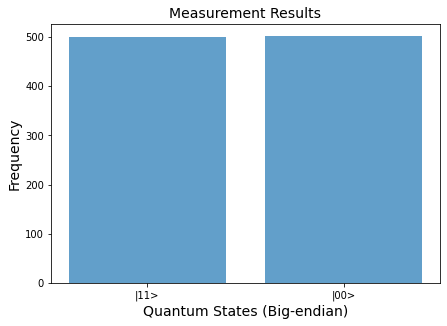

In [6]:
fig = plt.figure(figsize = (6,4))
ax = fig.add_axes([0.1,0.1,0.9,0.9])
ax.bar(results.keys(), results.values(),alpha=0.7)
ax.set_xlabel('Quantum States (Big-endian)',fontsize=14)
ax.set_ylabel('Frequency',fontsize=14)
ax.set_title('Measurement Results',fontsize=14)
plt.show()

In [7]:
# A random Quantum Circuit

qcircuit1 = [{ "gate": "H", "target": [0] },
            { "gate": "CNOT", "target": [0,1] },
            { "gate": "Y", "target": [0] },
            { "gate": "H", "target": [1] },
            { "gate": "CNOT", "target": [1,0] },
            { "gate": "Z", "target": [1] },
           ]

In [8]:
twoq = get_groundstate(nqubits=2) # get ground state
final_state1 = get_fstate(qcircuit1,twoq)  # get the final state for the given ground state and circuit
print(final_state1)

[[0.-0.5j]
 [0.+0.5j]
 [0.+0.5j]
 [0.+0.5j]]


In [9]:
results1 = get_counts(final_state1,shots=1000)  # obtain measurement results

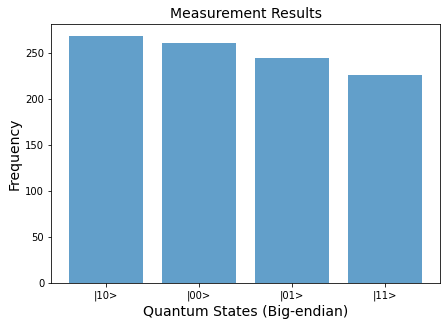

In [10]:
fig = plt.figure(figsize = (6,4))
ax = fig.add_axes([0.1,0.1,0.9,0.9])
ax.bar(results1.keys(), results1.values(),alpha=0.7)
ax.set_xlabel('Quantum States (Big-endian)',fontsize=14)
ax.set_ylabel('Frequency',fontsize=14)
ax.set_title('Measurement Results',fontsize=14)
plt.show()

## Three Qubit System

In [11]:
# A random Quantum Circuit

qcircuit2 = [{ "gate": "H", "target": [0] },
            { "gate": "H", "target": [1] },
            { "gate": "H", "target": [2] },
            { "gate": "CNOT", "target": [0,1] },
            { "gate": "Y", "target": [0] },
            { "gate": "CNOT", "target": [2,1] },
            { "gate": "Z", "target": [2] },
           ]

In [12]:
threeq = get_groundstate(nqubits=3) # get ground state
final_state2 = get_fstate(qcircuit2,threeq)  # get the final state for the given ground state and circuit
print(final_state2)

[[0.-0.35355339j]
 [0.-0.35355339j]
 [0.-0.35355339j]
 [0.-0.35355339j]
 [0.+0.35355339j]
 [0.+0.35355339j]
 [0.+0.35355339j]
 [0.+0.35355339j]]


In [13]:
results2 = get_counts(final_state2,shots=1000)  # obtain measurement results

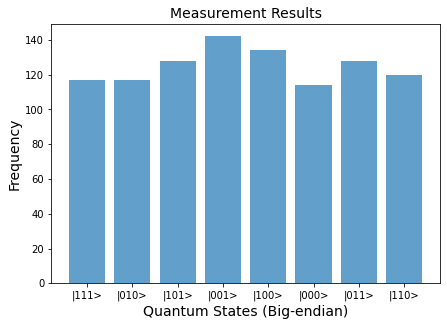

In [14]:
fig = plt.figure(figsize = (6,4))
ax = fig.add_axes([0.1,0.1,0.9,0.9])
ax.bar(results2.keys(), results2.values(),alpha=0.7)
ax.set_xlabel('Quantum States (Big-endian)',fontsize=14)
ax.set_ylabel('Frequency',fontsize=14)
ax.set_title('Measurement Results',fontsize=14)
plt.show()